# Heuristic Models For Seattle Weather

In [1]:
# import packges 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import datetime
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [2]:
# Load Data
df = pd.read_csv('https://raw.githubusercontent.com/Yasmeenmad/data_science_bootcamp/main/Week10/Intro_Machine_Learning1/seattle_weather_1948-2017.csv')

In [3]:
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


### Create functions to handle NaN values

In [4]:
def RAIN_INSERTION(cols):
    """
    Insert False where NaN values are present
    """
    RAIN=cols[0]
    if pd.isnull(RAIN):
        return False
    else:
        return RAIN

In [5]:
def PRCP_INSERTION(col):
    """
    Insert the Mean of PRCP where NaN values are present
    """
    PRCP=col[0]
    if pd.isnull(PRCP):
        return df['PRCP'].mean()
    else:
        return PRCP

In [6]:
# Apply the functions
df['RAIN']=df[['RAIN']].apply(RAIN_INSERTION,axis=1)

In [7]:
df['PRCP']=df[['PRCP']].apply(PRCP_INSERTION,axis=1)

In [8]:
# Check for NaN values
df[pd.isnull(df['RAIN'])]

,DATE,PRCP,TMAX,TMIN,RAIN


In [9]:
df[pd.isnull(df['PRCP'])]

,DATE,PRCP,TMAX,TMIN,RAIN


## Identifying Outliers

In [10]:
# First quartile (Q1)
Q1 = np.percentile(df['TMAX'], 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(df['TMAX'], 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1

# lower bound outliers --> Q1 - 1.5(IQR)
# higher bound outliers --> Q3 + 1.5 (IQR)


print(Q3+ 1.5*(IQR))

97.5


In [11]:
#Dropping the outliers from TMIN column
df=df.drop(df[df['TMIN']<17 ].index)


In [12]:
#Dropping the outliers from TMAX columns i.e. the value more than 100
df=df.drop(df[(df['TMAX']>97.5) | (df['TMAX']< 21.5)].index)


In [13]:
#Dropping the outliers from PRCP columns i.e. the value more than 0.275
df=df.drop(df[(df['PRCP']>0.25) | (df['PRCP']< -0.15) ].index)

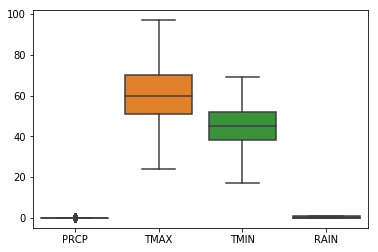

In [14]:
sns.boxplot(data=df)

### Coding a Heuristic by hand and evaluating

conditions:
- If it rained yesterday or the day before
- if max temperature from 30 to 70 for yesterday or the day before
- if min temperature from 25 to 60 for yesterday or the day before
- if precipitation of rain range from 0.01 to 5.02 for yesterday or the day before

then it will rain today 

In [15]:
# Reset index and drop index column
df = df.reset_index().drop("index", axis=1)

In [16]:
# Create function to perform our heuristic
def heuristic(df):
    
    """
    Simple heuristic:
    
    If it rained yesterday or the day before, if max temperature from 30 to 70 for yesterday or the day before, if min 
    temperature from 25 to 60 for yesterday or the day before and if precipitation of rain range from 0.01 to 5.02 
    for yesterday or the day before then it will rain else predict no rain
    
    Frist two rows are predicted false be default
    """
    
    preds = []
    for x in range(len(df)):
        # If first two rows then predict false
        if x <2:
            preds.append(False)
        else:

            if ((df.iloc[x-1]["RAIN"] == True) & (df.iloc[x-2]["RAIN"] == True) &
                ((df.iloc[x-1]["TMAX"] <= 70) & (df.iloc[x-1]["TMAX"] >= 30)) &
                ((df.iloc[x-2]["TMAX"] <= 70) & (df.iloc[x-2]["TMAX"] >= 30)) &
                ((df.iloc[x-1]["TMIN"] <= 60) & (df.iloc[x-1]["TMIN"] >= 25)) &
                ((df.iloc[x-2]["TMIN"] <= 60) & (df.iloc[x-2]["TMIN"] >= 25)) &
                ((df.iloc[x-1]["PRCP"] <= 5.02) & (df.iloc[x-1]["PRCP"] >= 0.01)) &
                ((df.iloc[x-2]["PRCP"] <= 5.02) & (df.iloc[x-2]["PRCP"] >= 0.01))):
                preds.append(True)

                
            else:
                # Predict false if the above is not true
                preds.append(False)
    return preds

(array([19638.,  2255.]),
 array([0.   , 0.125, 0.25 ]),
 <a list of 2 Patch objects>)

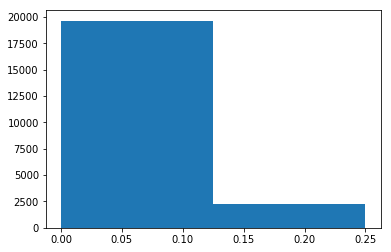

In [17]:
plt.hist(df['PRCP'], bins =2)

In [18]:
# Apply Heuristic
df["preds"] = heuristic(df)

df.head()

,DATE,PRCP,TMAX,TMIN,RAIN,preds
0,1948-01-05,0.17,45,32,True,False
1,1948-01-08,0.04,48,35,True,False
2,1948-01-09,0.12,50,31,True,True
3,1948-01-11,0.01,42,32,True,True
4,1948-01-12,0.00,41,26,False,True


In [19]:
# Determine Accuracy

# Create function to to find values

def calc_confuse(df):
    
    "Calculate all possible results of a confusion matrix"

    # Hold all possible values and set to zero
    FP = np.zeros(len(df))
    TP = np.zeros(len(df))
    FN = np.zeros(len(df))
    TN = np.zeros(len(df))
    
    for x in range(len(df)):
        
        # True Positive
        if (df["RAIN"].iloc[x] == True) & (df["preds"].iloc[x] == True):
            TP[x] = 1
        # True Negative
        elif (df["RAIN"].iloc[x] == False) & (df["preds"].iloc[x] == False):
            TN[x] = 1
        # False Negative
        elif (df["RAIN"].iloc[x] == True) & (df["preds"].iloc[x] == False):
            FN[x] = 1
        # False Positive
        else:
            FP[x] = 1
    
    return FP, TP, FN, TN

In [20]:
# Extract results and create columns for each
w,x,y,z = calc_confuse(df)

df["FP"] = w
df["TP"] = x
df["FN"] = y
df["TN"] = z
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN,preds,FP,TP,FN,TN
0,1948-01-05,0.17,45,32,True,False,0.0,0.0,1.0,0.0
1,1948-01-08,0.04,48,35,True,False,0.0,0.0,1.0,0.0
2,1948-01-09,0.12,50,31,True,True,0.0,1.0,0.0,0.0
3,1948-01-11,0.01,42,32,True,True,0.0,1.0,0.0,0.0
4,1948-01-12,0.00,41,26,False,True,1.0,0.0,0.0,0.0


### Determine the Precision, Recall, and Accuracy and compare your results with the Scikit-Learn Functions.

In [21]:
# Create a Function to Calculate Accuracy
def accuracy(TP, FP, TN, FN):
    return ((sum(TP)+sum(TN))/(sum(TP)+sum(FN) +sum(TN)+sum(FP)))

accuracy(df['TP'], df['FP'], df['TN'], df['FN'])

0.6837802037180835

In [22]:
# Accuracy by the accuracy_score
accuracy_score(df['RAIN'], df['preds'])

0.6837802037180835

In [23]:
# Create A Function to Calculate Precision
def precision(TP, FP):
    return (sum(TP)/(sum(TP)+sum(FP)))

precision(df['TP'], df['FP'])

0.5537389439828464

In [24]:
# precision by precision_score
precision_score(df['RAIN'], df['preds'])

0.5537389439828464

In [25]:
# Create A Function to Calculate Recall
def recall(TP, FN):
    return (sum(TP)/(sum(TP)+sum(FN)))

recall(df['TP'], df['FN'])

0.2820862916439104

In [26]:
# recall by recall_score
recall_score(df['RAIN'], df['preds'])

0.2820862916439104